# SNAI/ZEB Effect

Take SMC control/ZEB KD models and marginalize motif over random sequences to see if there's an effect.

In [1]:
import numpy as np

In [2]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [8]:
# local
sys.path.append("/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/")
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [5]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    model_control = keras.models.load_model("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bpnet/models/202100507_gc_neg_filt256_in2346_out2000/control/2021-05-07_01_54_44/7DETFO.h5")
    model_kd = keras.models.load_model("/users/surag/oak/projects/SMC_ZEB_KD_TomQ/bpnet/models/202100507_gc_neg_filt256_in2346_out2000/kd/2021-05-07_01_49_14/RugCJF.h5")

In [9]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [11]:
MODEL_INP_LEN = model_control.input_shape[0][1]
print(MODEL_INP_LEN)

2346


In [73]:
control_peaks =  pd.read_csv("~/oak/projects/SMC_ZEB_KD_TomQ/bpnet/peaks/control.overlap.merged.bed",
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "7"])
control_peaks.head()

,chr,start,end,1,2,3,4,5,6,7
0,chr1,628674,631020,.,.,.,.,.,.,1173
1,chr1,629889,632235,.,.,.,.,.,.,1173
2,chr1,630912,633258,.,.,.,.,.,.,1173
3,chr1,632858,635204,.,.,.,.,.,.,1173
4,chr1,777584,779930,.,.,.,.,.,.,1173


In [74]:
control_peaks.shape

(99523, 10)

In [57]:
from random import shuffle, choice, random
from copy import deepcopy

In [58]:
# random_positions = [(choice(["chr"+str(x) for x in range(1,23)]), int(random()*4e7)) for _ in range(128*10)]

In [84]:
# or choose peaks
random_positions = [(x["chr"], (x["start"]+x["end"])//2) for _,x in control_peaks.sample(128*10).iterrows()]

In [85]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts_control = []
random_pred_counts_kd = []
# random_pred_profile = []
# random_pred_profile_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model_control.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])
#     random_pred_profile.append(cur_pred[0])
    random_pred_counts_control.append(cur_pred[1])
    
    cur_pred = model_kd.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])
#     random_pred_profile_neur.append(cur_pred[0])
    random_pred_counts_kd.append(cur_pred[1])
    
random_pred_counts_control = np.vstack(random_pred_counts_control).ravel()
random_pred_counts_kd = np.vstack(random_pred_counts_kd).ravel()
# random_pred_profile = np.vstack(random_pred_profile).squeeze()
# random_pred_profile_neur = np.vstack(random_pred_profile_neur).squeeze()

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


In [86]:
def mod_sequence(s, rep, motif_start, motif_end):
    return s[:motif_start] + rep + s[motif_end:]

In [134]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts_control = []
synth_pred_counts_kd = []
# synth_pred_profile = []
# synth_pred_profile_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
        replacement = "CAGGTG"
        
        motif_start = MODEL_INP_LEN//2 
        motif_end = MODEL_INP_LEN//2 + len(replacement)        
        
        cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], replacement, motif_start, motif_end)
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model_control.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])
    synth_pred_counts_control.append(cur_pred[1])
#     synth_pred_profile.append(cur_pred[0])
    
    cur_pred = model_kd.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])
    synth_pred_counts_kd.append(cur_pred[1])
#     synth_pred_profile_neur.append(cur_pred[0])
    
synth_pred_counts_control = np.vstack(synth_pred_counts_control).ravel()
synth_pred_counts_kd = np.vstack(synth_pred_counts_kd).ravel()
# synth_pred_profile = np.vstack(synth_pred_profile).squeeze()
# synth_pred_profile_neur = np.vstack(synth_pred_profile_neur).squeeze()

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


In [135]:
np.median(random_pred_counts_control), np.median(random_pred_counts_kd)

(5.171695, 5.4110913)

In [136]:
np.median(synth_pred_counts_control), np.median(synth_pred_counts_kd)

(4.986595, 5.1779222)

In [137]:
np.median(synth_pred_counts_control-random_pred_counts_control)

-0.1402483

In [138]:
np.median(synth_pred_counts_kd-random_pred_counts_kd)

-0.15659904

In [139]:
import scipy.stats

In [140]:
scipy.stats.wilcoxon(random_pred_counts_control, synth_pred_counts_control)

WilcoxonResult(statistic=40746.0, pvalue=7.6345145748824785e-171)

In [141]:
np.sum(synth_pred_counts_control < random_pred_counts_control)/len(random_pred_counts_control)

0.871875

In [142]:
import matplotlib.pyplot as plt

<AxesSubplot:>

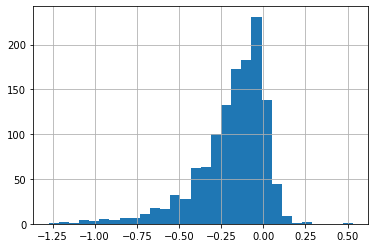

In [143]:
plt.rcParams["figure.figsize"] = (6,4)
pd.Series(synth_pred_counts_control - random_pred_counts_control).hist(bins=30)

In [102]:
from scipy.stats import gaussian_kde

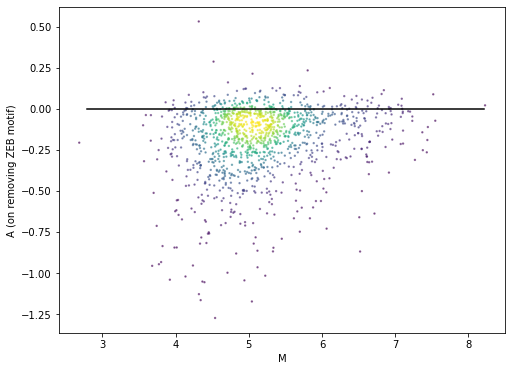

In [104]:
plt.rcParams["figure.figsize"] = (8,6)

x = (random_pred_counts_control+synth_pred_counts_control)/2
y = (synth_pred_counts_control-random_pred_counts_control)
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
plt.plot([min(random_pred_counts_control), max(random_pred_counts_control)], [0,0], '-k', label='y=2x+1')
plt.xlabel("M")
plt.ylabel("A (on removing ZEB motif)")
plt.savefig("image.jpg", dpi=300)

In [105]:
def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

### CDH1 promoter

3 ZEB motifs at promoter :

```
chr16:68737211-68737217 
chr16:68737262-68737268	
chr16:68737312-68737318
```

In [12]:
import pyBigWig

In [39]:
f = pyBigWig.open("/oak/stanford/groups/akundaje/surag/projects//scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx5.bw")

In [40]:
# f.close()

In [13]:
from copy import deepcopy
import scipy

In [14]:
start1 = 68737211
start2 = 68737262
start3 = 68737312

In [15]:
midpt = 68737261
origseq = str(hg38["chr16"][midpt-(MODEL_INP_LEN//2):midpt+(MODEL_INP_LEN//2)])

In [16]:
idx1 = (MODEL_INP_LEN//2 + (start1-midpt))
idx2 = (MODEL_INP_LEN//2 + (start2-midpt))
idx3 = (MODEL_INP_LEN//2 + (start3-midpt))

In [17]:
print(origseq[idx1:idx1+6],
      origseq[idx2:idx2+6],
      origseq[idx3:idx3+6])

CAGGTG CACCTG CACCTG


In [18]:
alt1seq = origseq[:idx1] + "CGAAGA" + origseq[idx1+6:]
alt2seq = origseq[:idx2] + "CGAAGA" + origseq[idx2+6:]
alt3seq = origseq[:idx3] + "CGAAGA" + origseq[idx3+6:]

alt4seq = deepcopy(alt1seq)
alt4seq = alt4seq[:idx2] + "CGAAGA" + alt4seq[idx2+6:]

alt5seq = deepcopy(alt4seq)
alt5seq = alt5seq[:idx3] + "CGAAGA" + alt5seq[idx3+6:]

In [19]:
cur_raw_seqs = one_hot.dna_to_one_hot([origseq, alt1seq, alt2seq, alt3seq, alt4seq, alt5seq])

In [55]:
prof, cts = model_control.predict([cur_raw_seqs, 
               np.zeros((cur_raw_seqs.shape[0],1)), 
               np.zeros((cur_raw_seqs.shape[0],2000,2))])

In [56]:
cts

array([[5.8772693],
       [6.2183785],
       [6.0754647],
       [5.9617567],
       [6.445064 ],
       [6.5378604]], dtype=float32)

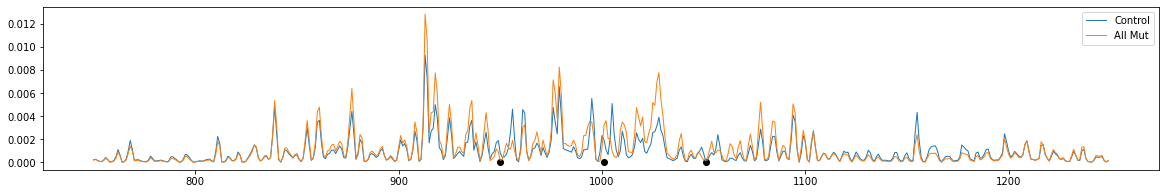

In [26]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0]))[750:1250], linewidth=1, label="Control")
# plt.plot(range(2000)[750:1250], (softmax(prof[1]))[750:1250], linewidth=1, label="Mut1")
# plt.plot(range(2000)[750:1250], (softmax(prof[2]))[750:1250], linewidth=1, label="Mut2")
# plt.plot(range(2000)[750:1250], (softmax(prof[3]))[750:1250], linewidth=1, label="Mut3")
plt.plot(range(2000)[750:1250], (softmax(prof[5]))[750:1250], linewidth=1, label="All Mut")
plt.scatter(1000+(start1-midpt), 0, c='k')
plt.scatter(1000+(start2-midpt), 0, c='k')
plt.scatter(1000+(start3-midpt), 0, c='k')
plt.legend()

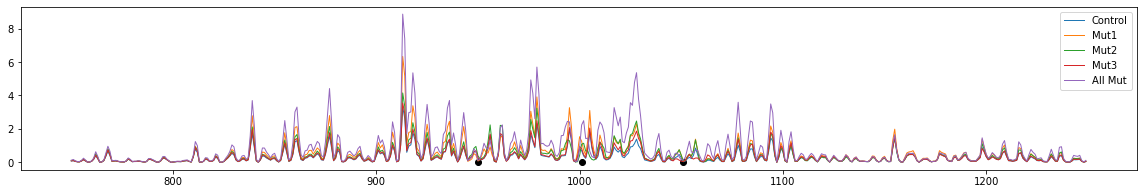

In [27]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0])*np.exp(cts[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1])*np.exp(cts[1]))[750:1250], linewidth=1, label="Mut1")
plt.plot(range(2000)[750:1250], (softmax(prof[2])*np.exp(cts[2]))[750:1250], linewidth=1, label="Mut2")
plt.plot(range(2000)[750:1250], (softmax(prof[3])*np.exp(cts[3]))[750:1250], linewidth=1, label="Mut3")
plt.plot(range(2000)[750:1250], (softmax(prof[5])*np.exp(cts[5]))[750:1250], linewidth=1, label="All Mut")
plt.scatter(1000+(start1-midpt), 0, c='k')
plt.scatter(1000+(start2-midpt), 0, c='k')
plt.scatter(1000+(start3-midpt), 0, c='k')
plt.legend()

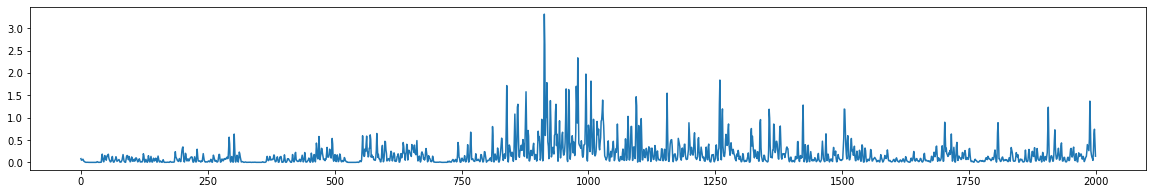

In [28]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[0])*np.exp(cts[0]))

In [29]:
plt.rcParams["figure.figsize"] = (20,3)
smoothed_observed = scipy.ndimage.gaussian_filter1d(np.nan_to_num(f.values("chr16", 68737261 - 1000, 68737261+1000)), 2)
plt.plot(range(2000), smoothed_observed)

NameError: name 'f' is not defined

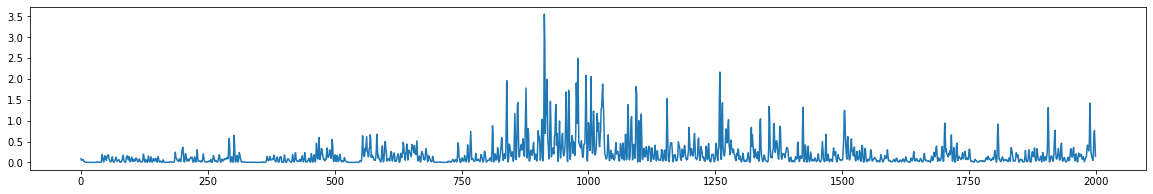

In [30]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[3])*np.exp(cts[3]))

In [58]:
np.nansum(f.values("chr1", 68737261 - 1000, 68737261+1000)) 

0.0

In [31]:
from shaputils import *
import shap

In [44]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model_control)

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model_control.input[0], model_control.input[1]],
         tf.reduce_sum(model_control.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

# profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
#         ([model.input[0], model.input[2]], weightedsum_meannormed_logits),
#         shuffle_several_times,
#         combine_mult_and_diffref=combine_mult_and_diffref)

In [45]:
X = cur_raw_seqs
counts_shap_scores = profile_model_counts_explainer.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores = np.multiply(X, counts_shap_scores[0])

Done 0 examples of 6
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [46]:
# profile_shap_scores = profile_model_profile_explainer.shap_values(
#         [X, np.zeros((X.shape[0], 2000, 2))], progress_message=100)
# projected_shap_scores = np.multiply(X, profile_shap_scores[0])

In [47]:
from modisco.visualization import viz_sequence

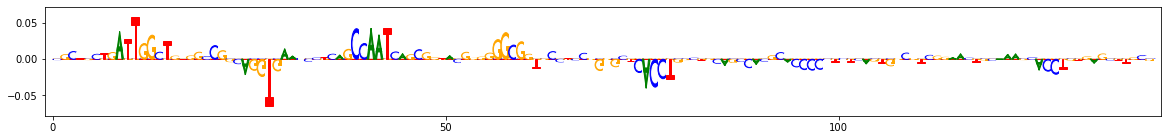

In [48]:
viz_sequence.plot_weights(projected_shap_scores[0][1100:1240], subticks_frequency=50)

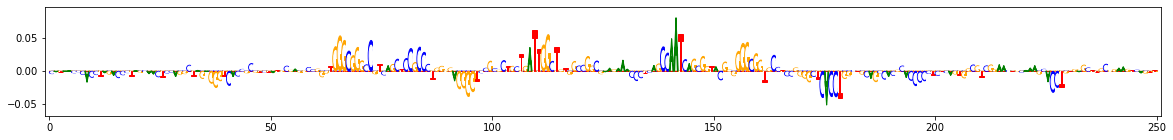

In [49]:
viz_sequence.plot_weights(projected_shap_scores[1][1000:1250], subticks_frequency=50)

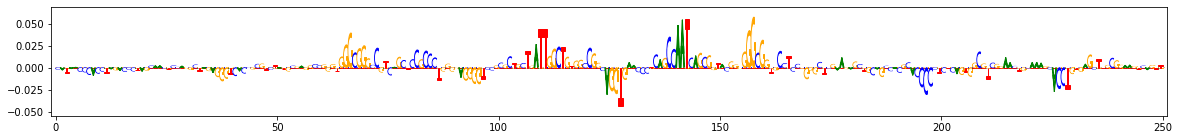

In [50]:
viz_sequence.plot_weights(projected_shap_scores[2][1000:1250], subticks_frequency=50)

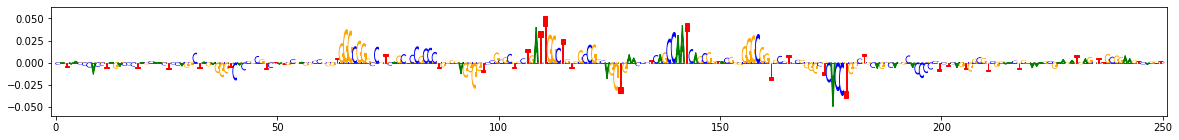

In [51]:
viz_sequence.plot_weights(projected_shap_scores[3][1000:1250], subticks_frequency=50)

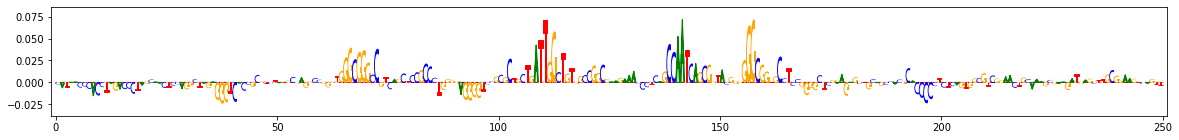

In [52]:
viz_sequence.plot_weights(projected_shap_scores[-1][1000:1250], subticks_frequency=50)

[<matplotlib.lines.Line2D at 0x7f0d4e257290>]

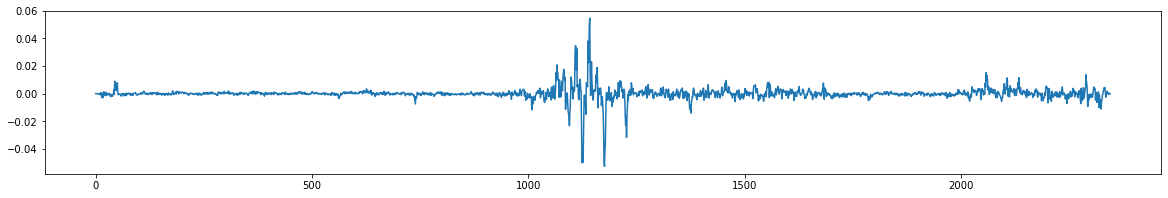

In [260]:
plt.plot(np.sum(projected_shap_scores[0],-1))